# Deep Learning for Computer Vision:  HW 3


## Computer Science: COMS W 4995 005


### Due: October 22, 2024

#### Problem 1: Multi Layer Perceptron from Scratch

a) You are given two dimensional input features from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

Let the layer dimensions be parameters passed when the network is created.

Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

Build and run your network using your own constructs. The code for doing this might look like what is shown in the next box below.

b) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

c) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

d) Re-use this same network on any data of your own choosing. You can increase the dimensionality of the features space as you like. You can also change the number of classes to just two or more than three to align with your data. Separate your data into three piles: training, testing, and validation. Use your validation data to decide when to stop training if appropriate. Use your testing set to compute the accuracy of you classfier. 

In [7]:
# NN = MLP()
# NN.add_layer('Hidden', dim_in=2, dim_out=16)
# NN.add_layer('Hidden', dim_in=16, dim_out=16)
# NN.add_layer('Hidden', dim_in=16, dim_out=16)
# NN.add_layer('Output', dim_in=16, dim_out=3)
# NN.add_layer('Loss', dim_in=3, dim_out=3)

# loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
# plot_loss(loss)
# plot_decision_regions(NN)

 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Let's start by importing some libraries.

In [8]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [ ]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

Let's message this data into a numpy format.

In [40]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [41]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

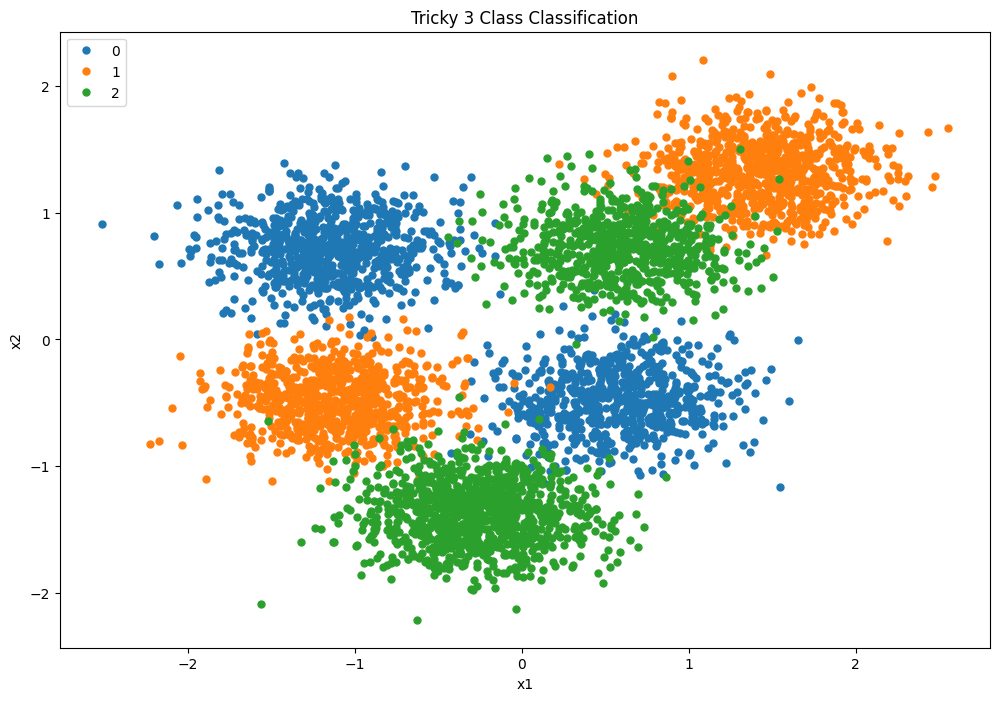

In [42]:
plot_data(X, y)

Now build your network. Good luck! 😉 

In [43]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Extract features and labels
X = data[['x1', 'x2']].values
y = data['y'].values.astype(int)

# Define activation functions
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    exp_scores = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Hidden Layer class
class HiddenLayer:
    def __init__(self, input_dim, output_dim, activation='relu'):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.biases = np.zeros((1, output_dim))
        self.activation = activation

    def forward(self, A_prev):
        self.A_prev = A_prev  # Store for use in backprop
        self.Z = np.dot(A_prev, self.weights) + self.biases
        if self.activation == 'relu':
            self.A = relu(self.Z)
        else:
            raise ValueError('Unsupported activation function')
        return self.A

    def backward(self, dA, learning_rate, reg_lambda):
        if self.activation == 'relu':
            dZ = dA * relu_derivative(self.Z)
        else:
            raise ValueError('Unsupported activation function')

        m = self.A_prev.shape[0]
        dW = (1 / m) * np.dot(self.A_prev.T, dZ) + reg_lambda * self.weights
        db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
        dA_prev = np.dot(dZ, self.weights.T)

        # Update parameters
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db

        return dA_prev

# Output Layer class
class OutputLayer:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.biases = np.zeros((1, output_dim))

    def forward(self, A_prev):
        self.A_prev = A_prev  # Store for use in backprop
        self.Z = np.dot(A_prev, self.weights) + self.biases
        self.A = softmax(self.Z)
        return self.A

    def backward(self, y_true, learning_rate, reg_lambda):
        m = y_true.shape[0]
        y_one_hot = np.zeros_like(self.A)
        y_one_hot[np.arange(m), y_true] = 1

        dZ = (self.A - y_one_hot) / m
        dW = np.dot(self.A_prev.T, dZ) + reg_lambda * self.weights
        db = np.sum(dZ, axis=0, keepdims=True)
        dA_prev = np.dot(dZ, self.weights.T)

        # Update parameters
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db

        return dA_prev

# MLP class
class MLP:
    def __init__(self):
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def backward(self, y_true, learning_rate, reg_lambda):
        dA = None  # Start with None; it will be set in the output layer
        for layer in reversed(self.layers):
            if isinstance(layer, OutputLayer):
                dA = layer.backward(y_true, learning_rate, reg_lambda)
            else:
                dA = layer.backward(dA, learning_rate, reg_lambda)

    def train(self, X, y, epochs, batch_size, learning_rate, reg_lambda):
        m = X.shape[0]
        for epoch in range(epochs):
            # Shuffle data
            permutation = np.random.permutation(m)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]

            # Mini-batch training
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                # Forward propagation
                A_out = self.forward(X_batch)

                # Backward propagation
                self.backward(y_batch, learning_rate, reg_lambda)

            # compute loss and accuracy
            if epoch % 10 == 0:
                predictions = self.predict(X)
                accuracy = np.mean(predictions == y) * 100
                print(f'Epoch {epoch}, Accuracy: {accuracy:.2f}%')

    def predict(self, X):
        A_out = self.forward(X)
        return np.argmax(A_out, axis=1)
    
# Plot decision regions
def plot_decision_regions(X, y, model):
    # Generate grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.02  # Mesh step size

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Predict classes for grid points
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot contour and training examples
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Decision Regions')
    plt.show()

#### Regualarization: 0, hidden layer: 1. Hidden units 3,8,16

Epoch 0, Accuracy: 35.06%
Epoch 10, Accuracy: 50.96%
Epoch 20, Accuracy: 54.66%
Epoch 30, Accuracy: 54.86%
Epoch 40, Accuracy: 52.46%
Epoch 50, Accuracy: 53.18%
Epoch 60, Accuracy: 53.76%
Epoch 70, Accuracy: 53.94%
Epoch 80, Accuracy: 53.98%
Epoch 90, Accuracy: 54.02%


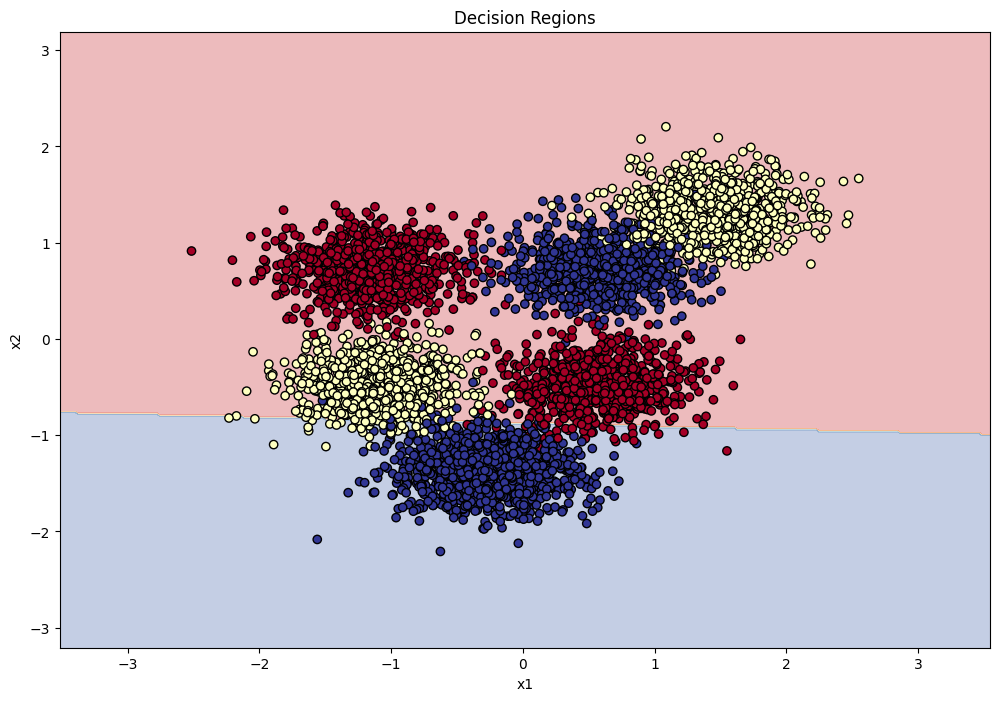

Epoch 0, Accuracy: 58.48%
Epoch 10, Accuracy: 92.18%
Epoch 20, Accuracy: 94.78%
Epoch 30, Accuracy: 95.82%
Epoch 40, Accuracy: 96.32%
Epoch 50, Accuracy: 96.56%
Epoch 60, Accuracy: 96.84%
Epoch 70, Accuracy: 96.88%
Epoch 80, Accuracy: 96.92%
Epoch 90, Accuracy: 96.86%


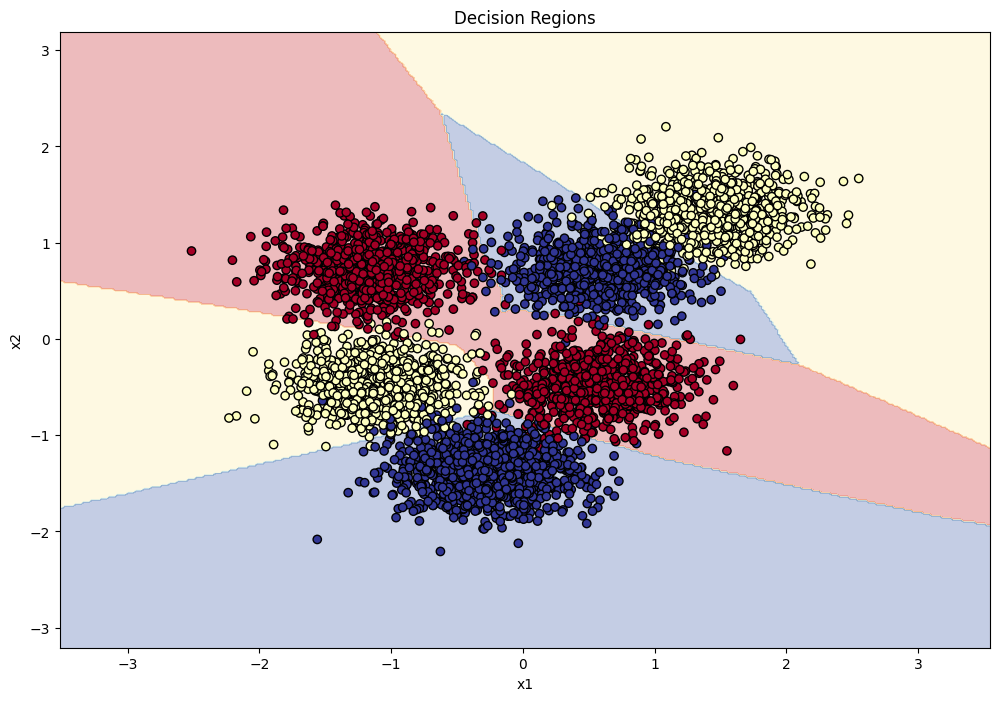

Epoch 0, Accuracy: 81.08%
Epoch 10, Accuracy: 92.24%
Epoch 20, Accuracy: 94.32%
Epoch 30, Accuracy: 95.08%
Epoch 40, Accuracy: 95.86%
Epoch 50, Accuracy: 96.04%
Epoch 60, Accuracy: 96.32%
Epoch 70, Accuracy: 96.34%
Epoch 80, Accuracy: 96.66%
Epoch 90, Accuracy: 96.86%


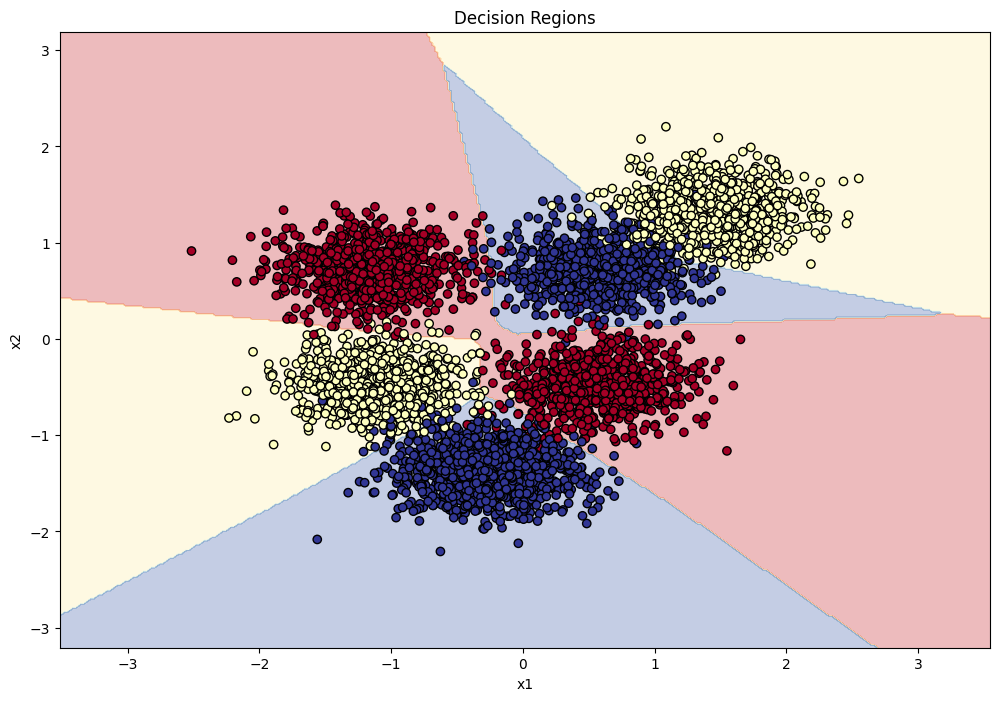

In [44]:
# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 1
num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
reg_lambda = 0  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 8
# num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
# reg_lambda = 0.001  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 16
# num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
# reg_lambda = 0.001  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

#### Regualarization: 0, hidden layer: 3. Hidden units 3,8,16

Epoch 0, Accuracy: 36.64%
Epoch 10, Accuracy: 36.64%
Epoch 20, Accuracy: 36.64%
Epoch 30, Accuracy: 36.64%
Epoch 40, Accuracy: 36.64%
Epoch 50, Accuracy: 36.64%
Epoch 60, Accuracy: 36.64%
Epoch 70, Accuracy: 36.64%
Epoch 80, Accuracy: 36.64%
Epoch 90, Accuracy: 36.64%


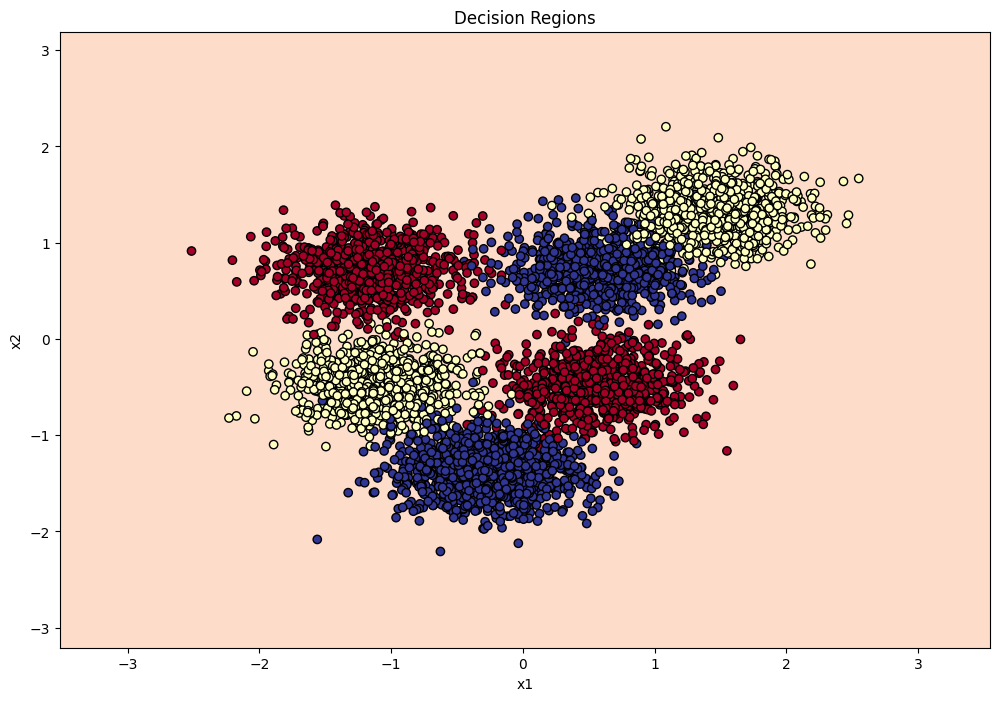

Epoch 0, Accuracy: 62.28%
Epoch 10, Accuracy: 93.14%
Epoch 20, Accuracy: 95.40%
Epoch 30, Accuracy: 96.36%
Epoch 40, Accuracy: 96.60%
Epoch 50, Accuracy: 96.94%
Epoch 60, Accuracy: 96.82%
Epoch 70, Accuracy: 97.12%
Epoch 80, Accuracy: 97.18%
Epoch 90, Accuracy: 97.16%


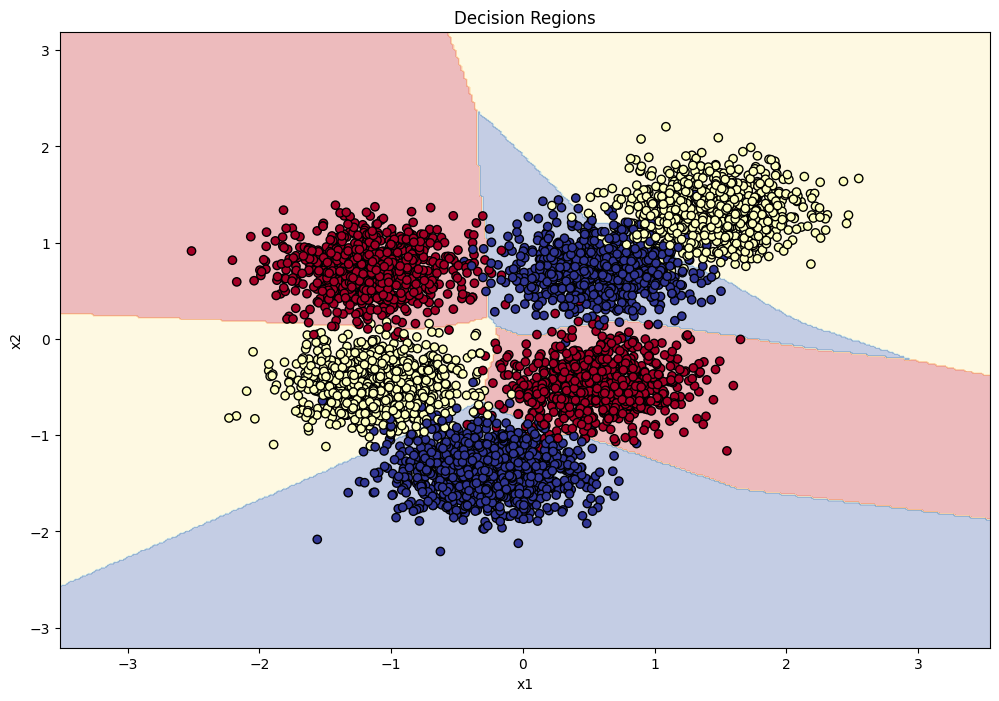

Epoch 0, Accuracy: 82.88%
Epoch 10, Accuracy: 94.96%
Epoch 20, Accuracy: 96.34%
Epoch 30, Accuracy: 96.42%
Epoch 40, Accuracy: 96.62%
Epoch 50, Accuracy: 96.82%
Epoch 60, Accuracy: 96.88%
Epoch 70, Accuracy: 96.98%
Epoch 80, Accuracy: 96.92%
Epoch 90, Accuracy: 97.16%


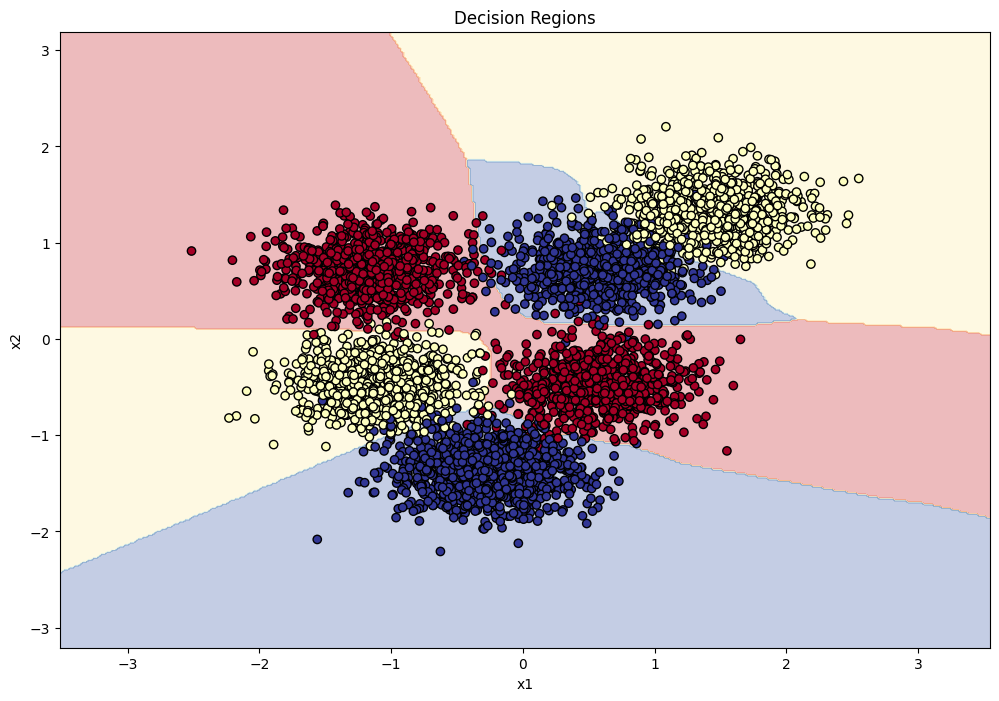

In [45]:
# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 1
num_hidden_layers = 3
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
reg_lambda = 0 # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 8
# num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
# reg_lambda = 0.001  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 16
# num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
# reg_lambda = 0.001  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

#### Regualarization: 0.01, hidden layer: 1. Hidden units 3,8,16

Epoch 0, Accuracy: 27.62%
Epoch 10, Accuracy: 43.66%
Epoch 20, Accuracy: 45.84%
Epoch 30, Accuracy: 45.90%
Epoch 40, Accuracy: 45.78%
Epoch 50, Accuracy: 45.94%
Epoch 60, Accuracy: 46.36%
Epoch 70, Accuracy: 45.56%
Epoch 80, Accuracy: 46.04%
Epoch 90, Accuracy: 45.92%


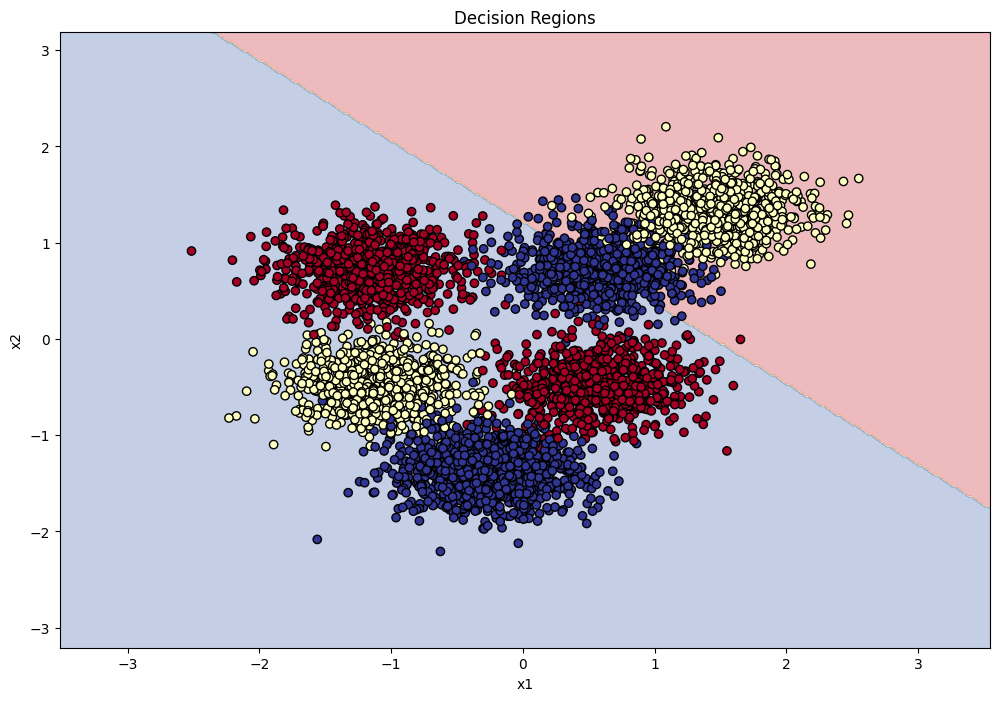

Epoch 0, Accuracy: 55.44%
Epoch 10, Accuracy: 79.94%
Epoch 20, Accuracy: 86.72%
Epoch 30, Accuracy: 90.26%
Epoch 40, Accuracy: 90.94%
Epoch 50, Accuracy: 90.90%
Epoch 60, Accuracy: 91.18%
Epoch 70, Accuracy: 91.08%
Epoch 80, Accuracy: 90.88%
Epoch 90, Accuracy: 91.08%


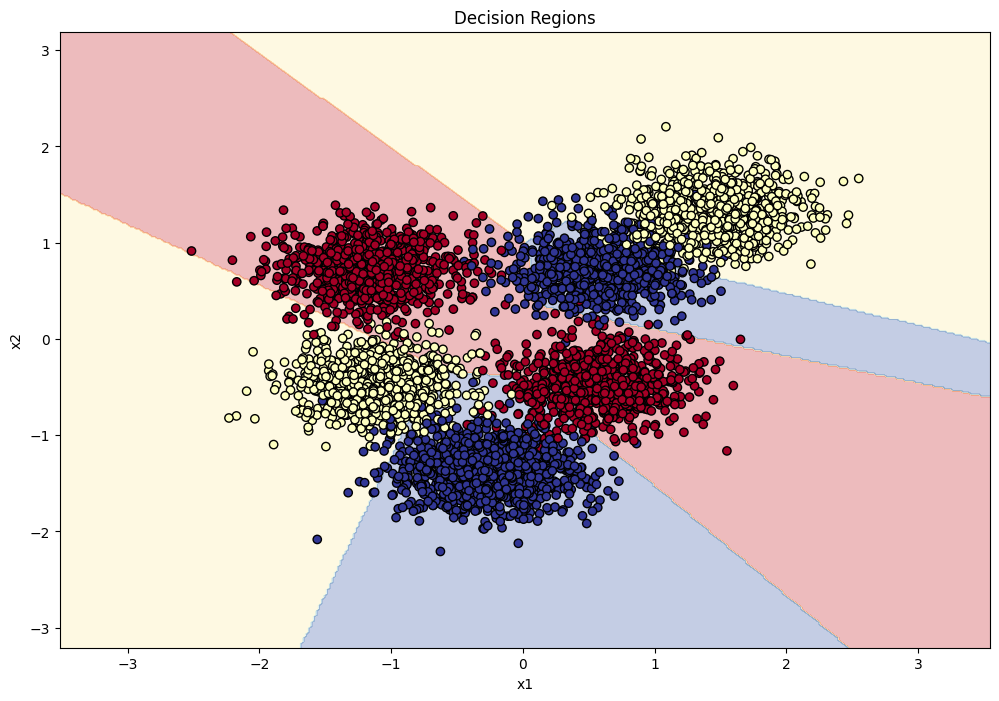

Epoch 0, Accuracy: 68.36%
Epoch 10, Accuracy: 91.56%
Epoch 20, Accuracy: 93.14%
Epoch 30, Accuracy: 92.52%
Epoch 40, Accuracy: 92.74%
Epoch 50, Accuracy: 92.30%
Epoch 60, Accuracy: 92.40%
Epoch 70, Accuracy: 92.24%
Epoch 80, Accuracy: 92.26%
Epoch 90, Accuracy: 92.36%


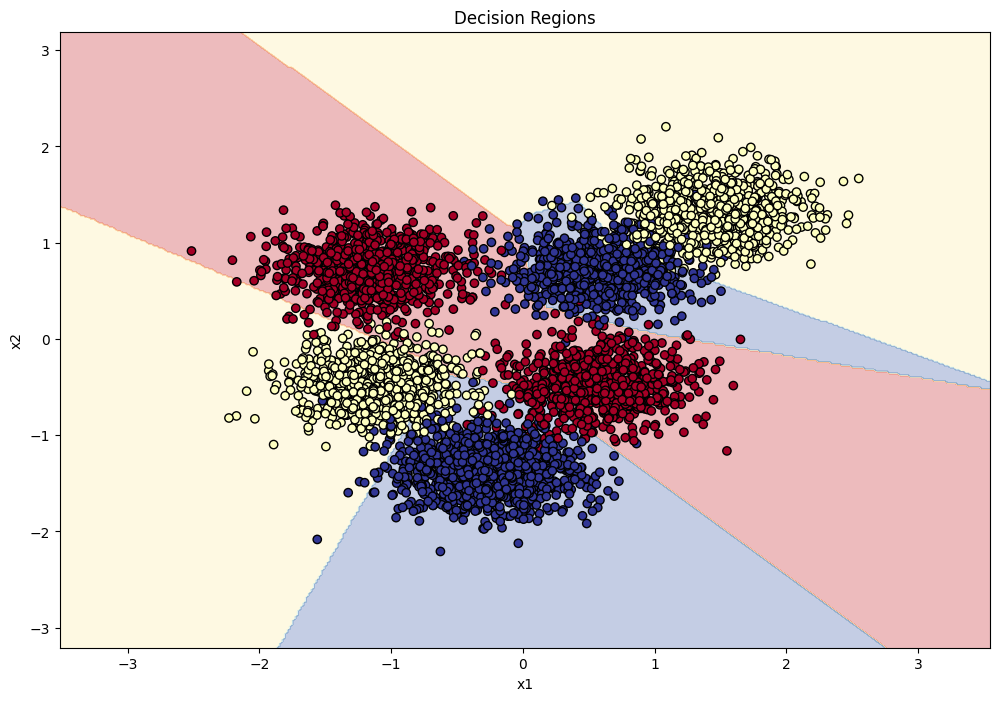

In [46]:
# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 1
num_hidden_layers = 1
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
reg_lambda = 0.01 # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 8
# num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
# reg_lambda = 0.001  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 16
# num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
# reg_lambda = 0.001  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

#### Regualarization: 0.01, hidden layer: 3. Hidden units 3,8,16

Epoch 0, Accuracy: 40.44%
Epoch 10, Accuracy: 51.16%
Epoch 20, Accuracy: 53.02%
Epoch 30, Accuracy: 54.54%
Epoch 40, Accuracy: 54.54%
Epoch 50, Accuracy: 54.40%
Epoch 60, Accuracy: 53.82%
Epoch 70, Accuracy: 54.64%
Epoch 80, Accuracy: 55.04%
Epoch 90, Accuracy: 54.58%


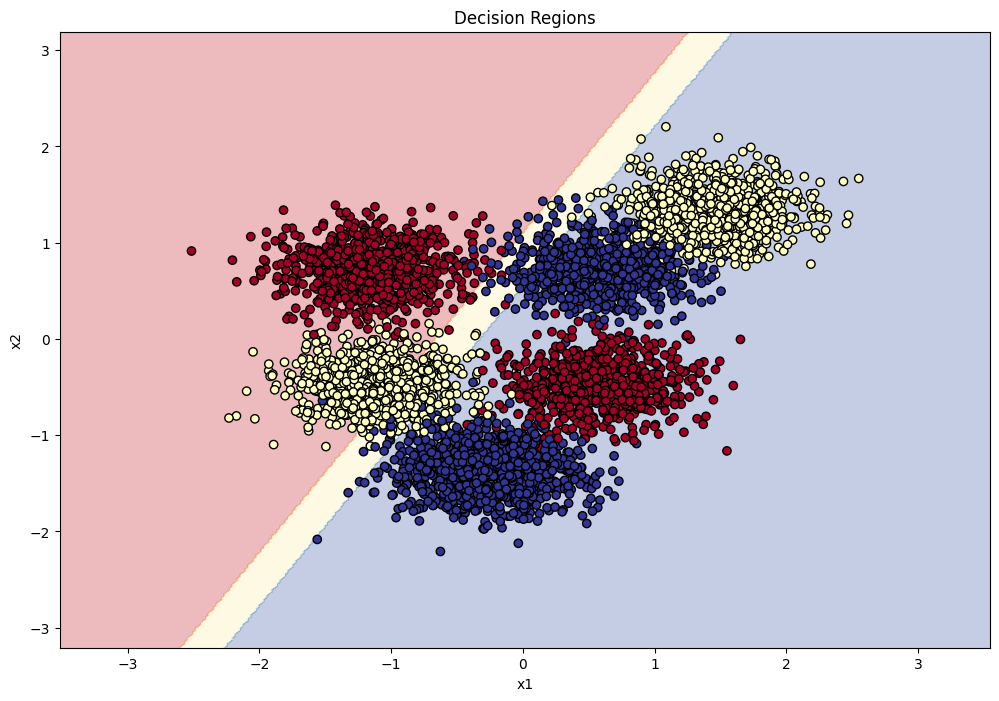

Epoch 0, Accuracy: 81.32%
Epoch 10, Accuracy: 94.30%
Epoch 20, Accuracy: 94.36%
Epoch 30, Accuracy: 94.64%
Epoch 40, Accuracy: 94.76%
Epoch 50, Accuracy: 95.12%
Epoch 60, Accuracy: 95.20%
Epoch 70, Accuracy: 95.18%
Epoch 80, Accuracy: 95.24%
Epoch 90, Accuracy: 95.26%


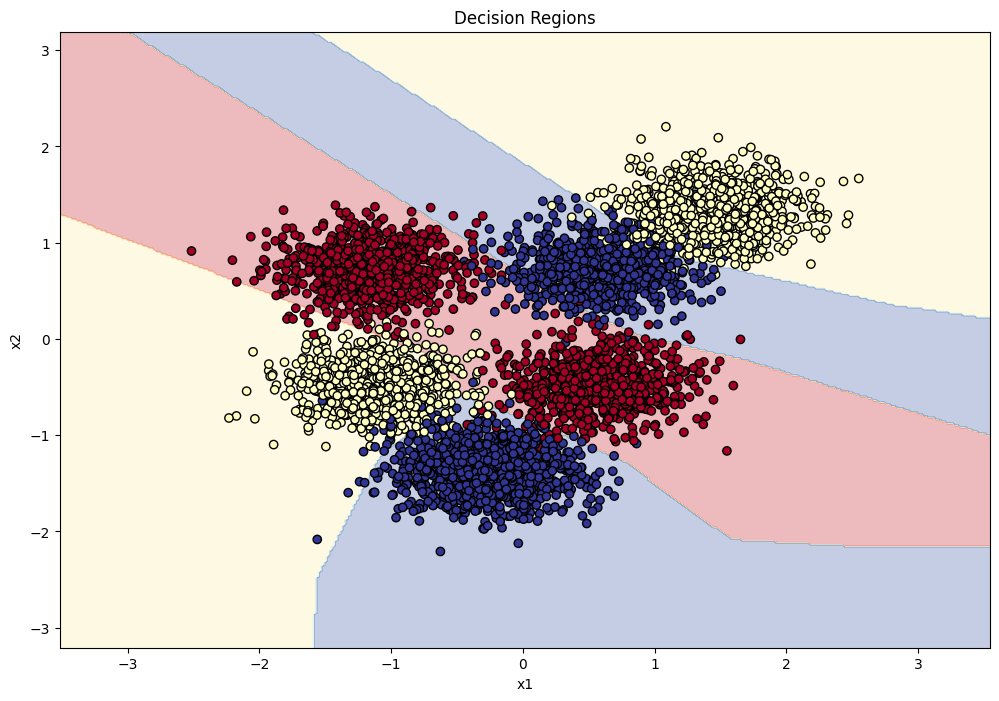

Epoch 0, Accuracy: 79.88%
Epoch 10, Accuracy: 95.16%
Epoch 20, Accuracy: 95.26%
Epoch 30, Accuracy: 95.06%
Epoch 40, Accuracy: 94.86%
Epoch 50, Accuracy: 94.84%
Epoch 60, Accuracy: 94.88%
Epoch 70, Accuracy: 95.04%
Epoch 80, Accuracy: 95.08%
Epoch 90, Accuracy: 95.14%


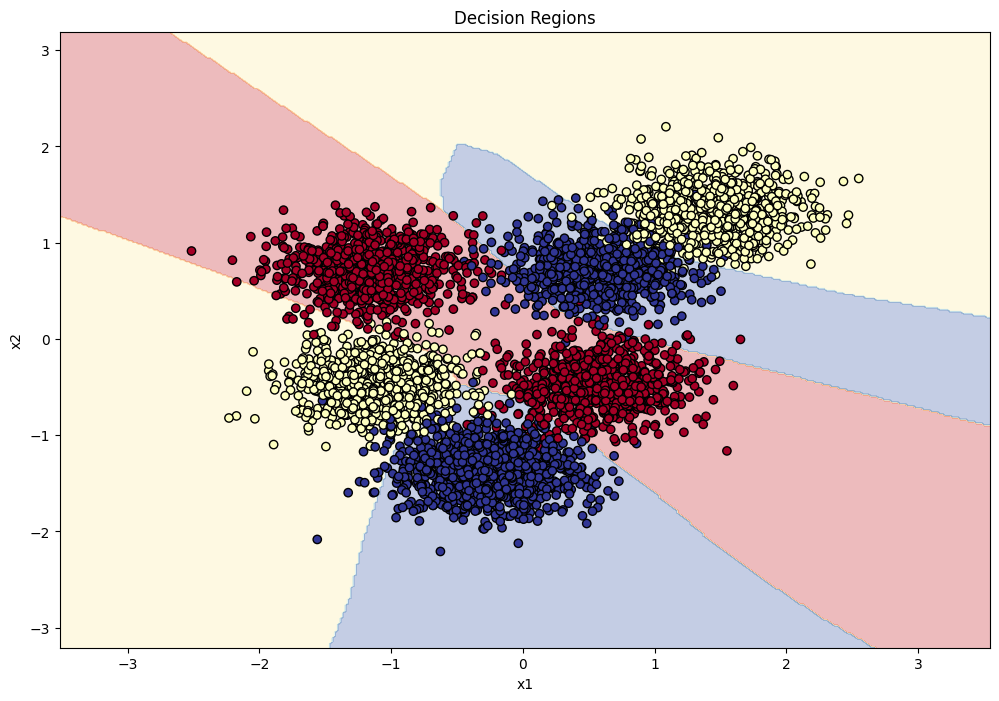

In [47]:
# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 1
num_hidden_layers = 3
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
reg_lambda = 0.01 # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 8
# num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
# reg_lambda = 0.001  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

# Parameters
input_dim = 2  # Number of input features
output_dim = 3  # Number of classes

# configurations
hidden_units = 16
# num_hidden_layers = 1 
activation_function = 'relu'

# Create MLP instance
mlp = MLP()

# Add layers
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation=activation_function))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation=activation_function))
mlp.add_layer(OutputLayer(hidden_units, output_dim))

# Training parameters
epochs = 100
batch_size = 8
learning_rate = 0.01
# reg_lambda = 0.001  # Regularization parameter

# Train the network
mlp.train(X, y, epochs, batch_size, learning_rate, reg_lambda)

# Plot the decision regions
plot_decision_regions(X, y, mlp)

#### Analaysis
- In theory, the higher regularization rate should contribute to higher accurate at a certain point prevent overfitting and simplify the model. We do see some semblence on more generalized shaped with regularization at 0.01, though not drastically different between reguarlization: 0. 
-Higher hidden units and hidden layers should also aid with higher accuracy. While it should increase copmlexity and compute, this is not noticable at a simple model like this
- These paramters being adjustable allows us to adjust which has the best fit

#### Using HW1 data 2 class classification with sunny or not (x = normalized water pressure, y = normalized humidity). Running with regualization: 0.01, hidden layer: 1, hidden units: 8

- Implemented with early stopping

data link: https://drive.google.com/drive/folders/11kh7EoDyqay9nC-ypZJF69wSTjJLgzDy?usp=drive_link

Epoch 0, Validation Loss: 0.9657
Epoch 10, Validation Loss: 0.7358
Epoch 20, Validation Loss: 0.6953
Epoch 30, Validation Loss: 0.6840
Epoch 40, Validation Loss: 0.6814
Epoch 50, Validation Loss: 0.6769
Early stopping at epoch 55
Test Accuracy: 75.83%


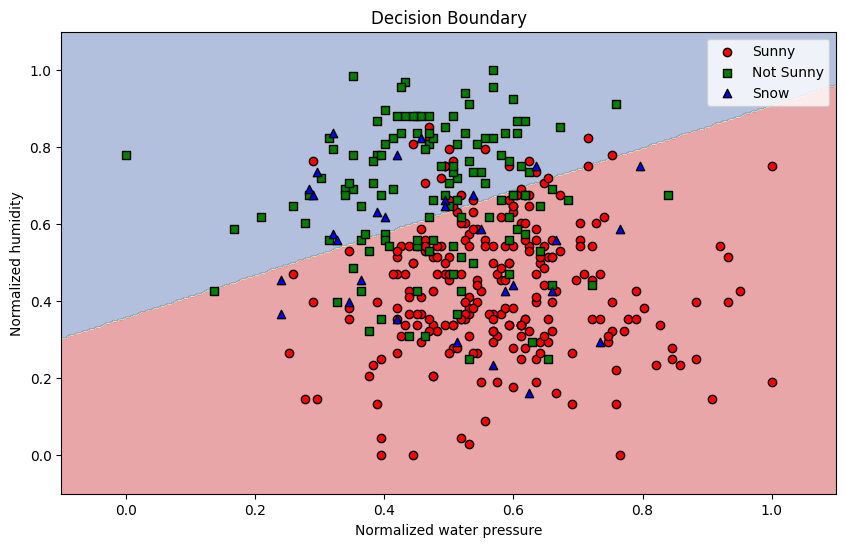

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv(r'C:\Users\Rosh\Desktop\all\Columbia\classes\Y4S1\DL_for_CV\hw3\raw_data\training-data.csv', encoding='ISO-8859-1')
df_test = pd.read_csv(r'C:\Users\Rosh\Desktop\all\Columbia\classes\Y4S1\DL_for_CV\hw3\raw_data\test-data.csv', encoding='ISO-8859-1')

# Prepare the features and labels
X = df[['Normalized water pressure', 'normalized humidity']].values
y_labels = df['Sunny or not'].map({'Sunny': 0, 'Not Sunny': 1, 'Snow': 2}).values

# Manual one-hot encoding
def one_hot_encode(labels, num_classes):
    encoded = np.zeros((labels.size, num_classes))
    encoded[np.arange(labels.size), labels] = 1
    return encoded

y = one_hot_encode(y_labels, 3)  # 3 classes: Sunny, Not Sunny, Snow

# Manual train-test split
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.random.permutation(X.shape[0])
    test_set_size = int(X.shape[0] * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the test set
X_test = df_test[['Normalized water pressure', 'normalized humidity']].values
y_test_labels = df_test['Sunny or not'].map({'Sunny': 0, 'Not Sunny': 1, 'Snow': 2}).values
y_test = one_hot_encode(y_test_labels, 3)

# Define activation functions and derivatives
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float)

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))  # Stabilize softmax
    return expZ / np.sum(expZ, axis=1, keepdims=True)

# Define layer classes
class HiddenLayer:
    def __init__(self, input_dim, output_dim, activation='relu'):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.biases = np.zeros((1, output_dim))
        self.activation = activation

    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = np.dot(A_prev, self.weights) + self.biases
        if self.activation == 'relu':
            self.A = relu(self.Z)
        else:
            raise ValueError('Unsupported activation function')
        return self.A

    def backward(self, dA, learning_rate, reg_lambda):
        if self.activation == 'relu':
            dZ = dA * relu_derivative(self.Z)
        else:
            raise ValueError('Unsupported activation function')
        m = self.A_prev.shape[0]
        dW = (1 / m) * np.dot(self.A_prev.T, dZ) + reg_lambda * self.weights
        db = (1 / m) * np.sum(dZ, axis=0, keepdims=True)
        dA_prev = np.dot(dZ, self.weights.T)
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db
        return dA_prev

class OutputLayerMultiClass:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
        self.biases = np.zeros((1, output_dim))

    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = np.dot(A_prev, self.weights) + self.biases
        self.A = softmax(self.Z)
        return self.A

    def backward(self, y_true, learning_rate, reg_lambda):
        m = y_true.shape[0]
        dZ = (self.A - y_true) / m
        dW = np.dot(self.A_prev.T, dZ) + reg_lambda * self.weights
        db = np.sum(dZ, axis=0, keepdims=True)
        dA_prev = np.dot(dZ, self.weights.T)
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db
        return dA_prev

class MLP:
    def __init__(self):
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        A = X
        for layer in self.layers:
            A = layer.forward(A)
        return A

    def backward(self, y_true, learning_rate, reg_lambda):
        dA = None
        for layer in reversed(self.layers):
            if isinstance(layer, OutputLayerMultiClass):
                dA = layer.backward(y_true, learning_rate, reg_lambda)
            else:
                dA = layer.backward(dA, learning_rate, reg_lambda)

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, reg_lambda, patience=5):
        m = X_train.shape[0]
        best_val_loss = np.inf
        patience_counter = 0

        for epoch in range(epochs):
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Mini-batch training
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]

                # Forward propagation
                A_out = self.forward(X_batch)

                # Backward propagation
                self.backward(y_batch, learning_rate, reg_lambda)

            # Validation loss with multi-class cross-entropy
            val_predictions = self.forward(X_val)
            val_loss = -np.sum(y_val * np.log(val_predictions + 1e-8)) / y_val.shape[0]

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch}')
                break

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Validation Loss: {val_loss:.4f}')

    def predict(self, X):
        A_out = self.forward(X)
        return np.argmax(A_out, axis=1)

# Define parameters
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_units = 8
num_hidden_layers = 1
learning_rate = 0.01
epochs = 100
batch_size = 8
reg_lambda = 0.01

# Create MLP instance and add layers
mlp = MLP()
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation='relu'))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation='relu'))
mlp.add_layer(OutputLayerMultiClass(hidden_units, output_dim))

# Train the network
mlp.train(X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, reg_lambda)

# Evaluate on test set
test_predictions = mlp.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_predictions == y_test_labels) * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Plot decision boundary function with legends
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.005

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    cmap_light = plt.cm.RdYlBu
    cmap_bold = ['red', 'green', 'blue']

    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

    labels = ['Sunny', 'Not Sunny', 'Snow']
    markers = ['o', 's', '^']

    for idx, label in enumerate(labels):
        plt.scatter(
            X[y == idx, 0],
            X[y == idx, 1],
            c=cmap_bold[idx],
            edgecolors='k',
            marker=markers[idx],
            label=label
        )

    plt.xlabel('Normalized water pressure')
    plt.ylabel('Normalized humidity')
    plt.title('Decision Boundary')
    plt.legend()
    plt.show()

# Before plotting, ensure y_test_labels are used (integer labels)
plot_decision_boundary(X_test, y_test_labels, mlp)


Epoch 0, Validation Loss: 0.8362
Epoch 10, Validation Loss: 0.6574
Epoch 20, Validation Loss: 0.6476
Epoch 30, Validation Loss: 0.6427
Early stopping at epoch 40
Test Accuracy: 76.84%


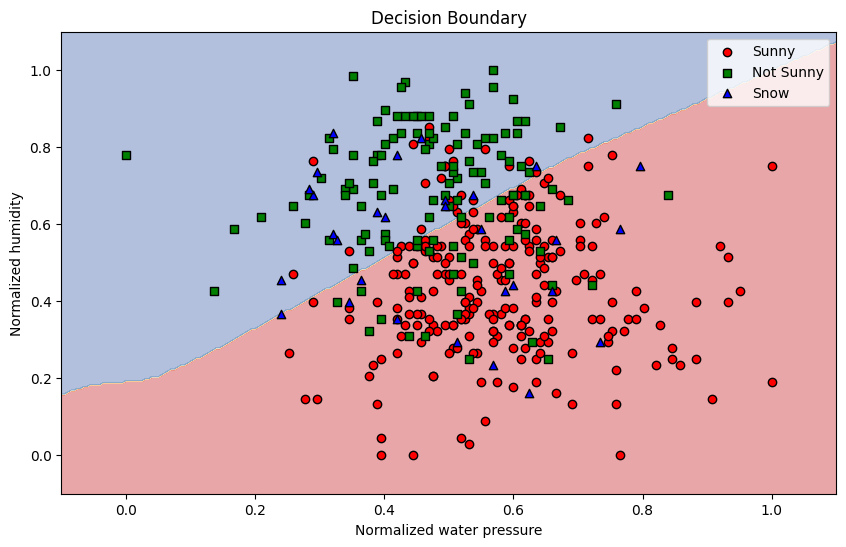

In [6]:
# Define parameters
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_units = 16
num_hidden_layers = 3
learning_rate = 0.01
epochs = 100
batch_size = 8
reg_lambda = 0.001

# Create MLP instance and add layers
mlp = MLP()
mlp.add_layer(HiddenLayer(input_dim, hidden_units, activation='relu'))
for _ in range(num_hidden_layers - 1):
    mlp.add_layer(HiddenLayer(hidden_units, hidden_units, activation='relu'))
mlp.add_layer(OutputLayerMultiClass(hidden_units, output_dim))

# Train the network
mlp.train(X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate, reg_lambda)

# Evaluate on test set
test_predictions = mlp.predict(X_test)
# y_test_labels are already defined earlier
test_accuracy = np.mean(test_predictions == y_test_labels) * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')


# Before plotting, ensure y_test_labels are used (integer labels)
plot_decision_boundary(X_test, y_test_labels, mlp)

#### Analysis
- We see that changing the paramter does indeed affect it's accuracy and decision boundary, with number of hidden units seeming to overfit and reduce accuracy. This phenomal will be more apparent with the increase of data points and a more complex data set. This data set also seems to not have a distinct enough difference based on the selected paramter to select between sunny, snow or others

#### Problem 2: Multi Layer Perceptron using Pytorch


Repeat all of Problem 1, but now implement everything in Pytorch. You are free to use Pytorch libraries to do this and do not need to write the code for the layers, training, etc. yourself. 

Epoch 0, Loss: 0.4410
Epoch 10, Loss: 0.1052
Epoch 20, Loss: 0.1045
Epoch 30, Loss: 0.1002
Epoch 40, Loss: 0.0996
Epoch 50, Loss: 0.0995
Epoch 60, Loss: 0.0999
Epoch 70, Loss: 0.1003
Epoch 80, Loss: 0.0996
Epoch 90, Loss: 0.1033
Accuracy: 96.14%


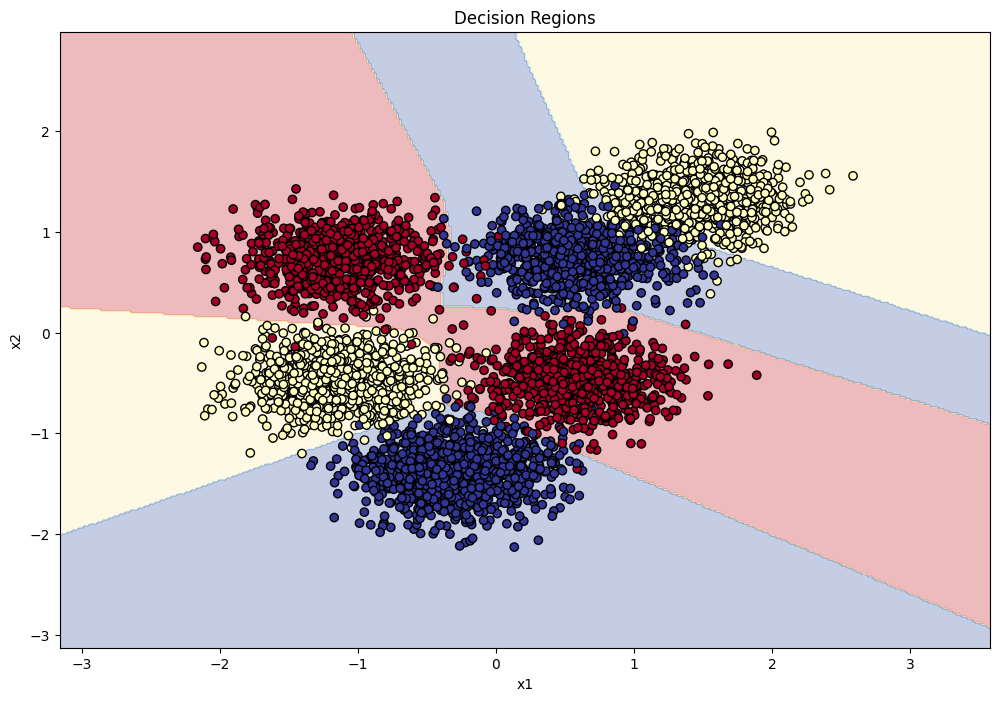

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

# Normalize data
data['x1'] = (data['x1'] - data['x1'].mean()) / data['x1'].std()
data['x2'] = (data['x2'] - data['x2'].mean()) / data['x2'].std()

# Extract features and labels
X = data[['x1', 'x2']].values
y = data['y'].values.astype(int)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Define layer classes
class HiddenLayer(nn.Module):
    def __init__(self, input_dim, output_dim, activation='relu'):
        super(HiddenLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU()
        else:
            raise ValueError('Unsupported activation function')

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        return x

class OutputLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(OutputLayer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.linear(x)
        return x

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def train_model(self, X_train, y_train, epochs, batch_size, learning_rate, reg_lambda):
        dataset = torch.utils.data.TensorDataset(X_train, y_train)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        optimizer = optim.Adam(self.parameters(), lr=learning_rate, weight_decay=reg_lambda)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            total_loss = 0
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {total_loss / len(dataloader):.4f}')

    def predict(self, X):
        with torch.no_grad():
            outputs = self.forward(X)
            _, predicted = torch.max(outputs, 1)
            return predicted

# Parameters
input_dim = X_tensor.shape[1]
output_dim = len(np.unique(y))
hidden_units = [3, 8, 16]  # You can adjust this list
epochs = 100
batch_size = 8
learning_rate = 0.01
reg_lambda = 0.001

# Create and build the network
mlp = MLP()
prev_dim = input_dim
for units in hidden_units:
    mlp.add_layer(HiddenLayer(prev_dim, units, activation='relu'))
    prev_dim = units
mlp.add_layer(OutputLayer(prev_dim, output_dim))

# Train the network
mlp.train_model(X_tensor, y_tensor, epochs, batch_size, learning_rate, reg_lambda)

# Evaluate the model
predictions = mlp.predict(X_tensor)
accuracy = (predictions == y_tensor).float().mean().item() * 100
print(f'Accuracy: {accuracy:.2f}%')

# Plot the decision regions
def plot_decision_regions(X, y, model):
    x_min, x_max = X[:, 0].min().item() - 1, X[:, 0].max().item() + 1
    y_min, y_max = X[:, 1].min().item() - 1, X[:, 1].max().item() + 1
    h = 0.02

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

    Z = model.predict(grid_tensor)
    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y.numpy(), edgecolor='k', cmap=plt.cm.RdYlBu)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Decision Regions')
    plt.show()

plot_decision_regions(X_tensor, y_tensor, mlp)


#### Repeating pytorch process on own data
google drive link: https://drive.google.com/drive/folders/11kh7EoDyqay9nC-ypZJF69wSTjJLgzDy?usp=drive_link

Epoch 0, Training Loss: 0.8413, Validation Loss: 0.7190, Validation Accuracy: 70.00%
Early stopping at epoch 6
Test Accuracy: 74.30%


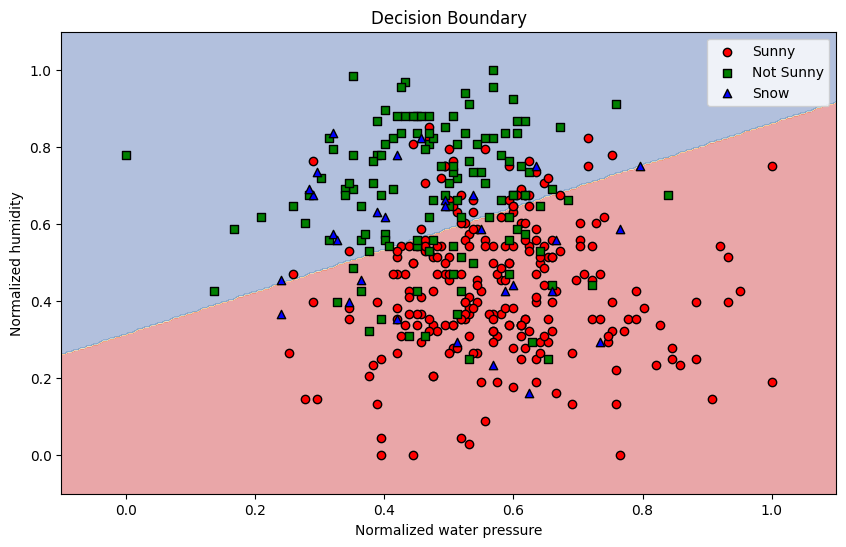

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Load the data
df = pd.read_csv(r'C:\Users\Rosh\Desktop\all\Columbia\classes\Y4S1\DL_for_CV\hw3\raw_data\training-data.csv', encoding='ISO-8859-1')
df_test = pd.read_csv(r'C:\Users\Rosh\Desktop\all\Columbia\classes\Y4S1\DL_for_CV\hw3\raw_data\test-data.csv', encoding='ISO-8859-1')

# Prepare the features and labels
X = df[['Normalized water pressure', 'normalized humidity']].values
y_labels = df['Sunny or not'].map({'Sunny': 0, 'Not Sunny': 1, 'Snow': 2}).values  # Integer labels

# Split into training and validation sets
X_train, X_val, y_train_labels, y_val_labels = train_test_split(
    X, y_labels, test_size=0.2, random_state=42)

# Prepare the test set
X_test = df_test[['Normalized water pressure', 'normalized humidity']].values
y_test_labels = df_test['Sunny or not'].map({'Sunny': 0, 'Not Sunny': 1, 'Snow': 2}).values

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_labels_tensor = torch.tensor(y_train_labels, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_labels_tensor = torch.tensor(y_val_labels, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_labels_tensor = torch.tensor(y_test_labels, dtype=torch.long)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, num_hidden_layers, activation='relu'):
        super(MLP, self).__init__()
        layers = []
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_units))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leaky_relu':
            layers.append(nn.LeakyReLU())
        else:
            raise ValueError('Unsupported activation function')
        # Hidden layers
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_units, hidden_units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
        # Output layer
        layers.append(nn.Linear(hidden_units, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Define parameters
input_dim = X_train.shape[1]
output_dim = 3  # Number of classes
hidden_units = 8
num_hidden_layers = 1
activation_function = 'relu'
learning_rate = 0.01
epochs = 100
batch_size = 8
reg_lambda = 0.01  # L2 regularization parameter

# Create model instance
model = MLP(input_dim, hidden_units, output_dim, num_hidden_layers, activation=activation_function)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg_lambda)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop with early stopping
best_val_loss = np.inf
patience = 5
patience_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_labels_tensor)
        _, val_predicted = torch.max(val_outputs, 1)
        val_accuracy = (val_predicted == y_val_labels_tensor).float().mean()
    
    # Early Stopping Check
    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        patience_counter = 0
        # Optionally save the model
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch}')
        break

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Training Loss: {total_loss / len(train_loader):.4f}, "
      f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy.item()*100:.2f}%")


# Evaluate on test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, test_predicted = torch.max(test_outputs, 1)
    test_accuracy = (test_predicted == y_test_labels_tensor).float().mean()
    print(f'Test Accuracy: {test_accuracy.item()*100:.2f}%')

# Plot the decision boundary
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    h = 0.005

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        outputs = model(grid_tensor)
        _, Z = torch.max(outputs, 1)
    Z = Z.numpy().reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    cmap_light = plt.cm.RdYlBu
    cmap_bold = ['red', 'green', 'blue']

    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

    labels = ['Sunny', 'Not Sunny', 'Snow']
    markers = ['o', 's', '^']

    for idx, label in enumerate(labels):
        plt.scatter(
            X[y == idx, 0],
            X[y == idx, 1],
            c=cmap_bold[idx],
            edgecolors='k',
            marker=markers[idx],
            label=label
        )

    plt.xlabel('Normalized water pressure')
    plt.ylabel('Normalized humidity')
    plt.title('Decision Boundary')
    plt.legend()
    plt.show()

# Plot the decision boundary
plot_decision_boundary(X_test, y_test_labels, model)
